In [113]:
# Standard Library Imports
import os
import json

# Data Manipulation and Processing
import pandas as pd
import numpy as np
import re
from pandas import json_normalize
from tqdm.notebook import tqdm

# Text Processing
import emoji
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation



# Machine Learning Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import joblib

# Statistical Utilities
from scipy.stats import mode

In [114]:
model_proposed = joblib.load('Semi_supervised_models_12_13_10.joblib')
model_baseline = joblib.load('Initial_Models_12_11_supervised_dropped_5_2.joblib')
test_df = pd.read_parquet('../../data/final/testing/combined/combined_testing_accounts_ROBERTA_LDA_missing_dropped_2.parquet')
train_df = pd.read_parquet('../../data/final/labeled/combined/ROBERTA/train_labeled_LDA_missing_dropped.parquet')
val_df = pd.read_parquet('../../data/final/labeled/combined/ROBERTA/val_labeled_LDA_missing_dropped.parquet')

c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [115]:
features_LDA = ['user_id', 'username', 'username_uppercase', 'username_lowercase',
                'username_numeric', 'username_special', 'username_length', 'username_se', 'is_missing_username',
                'screenname', 'screenname_uppercase', 'screenname_lowercase',
                'screenname_numeric', 'screenname_special', 'screenname_length',
                'screenname_se', 'screenname_emoji', 'screenname_hashtag',
                'screenname_word', 'is_missing_screenname', 'description', 'description_length',
                'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description',  
                'user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                'is_missing_user_metadata', 'post_md_like_mean',
                'post_md_like_std', 'post_md_retweet_mean', 'post_md_retweet_std',
                'post_md_reply_mean', 'post_md_reply_std',
                'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std',
                'post_sentiment_score_mean', 'post_sentiment_score_std',
                'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                'post_sentiment_numeric_prop_positive',
                'post_sentiment_numeric_prop_neutral',
                'post_sentiment_numeric_prop_negative', 'is_missing_post_text']

feature_sets_LDA = {
    'username': ['username_uppercase', 'username_lowercase', 'username_numeric',
                 'username_special', 'username_length', 'username_se', 'is_missing_username'],  # Add all username features
    'screenname': ['screenname_uppercase', 'screenname_lowercase',
                   'screenname_numeric', 'screenname_special', 'screenname_length',
                   'screenname_se', 'is_missing_screenname'],  # Add all screenname features
    'description': ['description_length', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
                'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'is_missing_description'],  # Add all description features
    'user_metadata': ['user_md_follower', 'user_md_following', 'user_md_follow_ratio',
                      'user_md_total_post', 'user_md_total_like', 'user_md_verified',
                      'is_missing_user_metadata'],  # Add user metadata features
    'post': ['post_md_like_mean', 'post_md_like_std', 'post_md_retweet_mean',
                      'post_md_retweet_std', 'post_md_reply_mean', 'post_md_reply_std',
                      'is_missing_post_metadata', 'post_text_length_mean', 'post_text_length_std', 'post_sentiment_score_mean',
                  'post_sentiment_score_std', 'post_sentiment_numeric_mean', 'post_sentiment_numeric_std',
                  'post_sentiment_numeric_prop_positive', 'post_sentiment_numeric_prop_neutral',
                  'post_sentiment_numeric_prop_negative', 'is_missing_post_text']  # Add post text features
}

In [116]:
X_train = train_df[features_LDA]  # All feature columns from the training dataset
y_train = train_df['label']    # Label column from the training dataset

X_test = test_df[features_LDA]  # All feature columns from the validation dataset
y_test = test_df['label']    # Label column from the validation dataset


X_val = val_df[features_LDA]  # All feature columns from the validation dataset
y_val = val_df['label']    # Label column from the validation dataset

In [117]:
# Initialize arrays to accumulate weighted probabilities
bot_prob_sum = np.zeros(len(X_test))
human_prob_sum = np.zeros(len(X_test))
total_weights = np.zeros(len(X_test))  # To normalize the weighted sums

# Define completeness threshold for assigning full weights
completeness_threshold = 0.75

# Initialize array for calibrated models
calibrated_models = {}

# Initialize a dictionary to store metrics for each individual model
individual_model_metrics = {}

# Apply Platt's scaling to each model using CalibratedClassifierCV
# Change model
for feature_name, models in model_baseline.items():
    calibrated_model = CalibratedClassifierCV(estimator=models, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_val[feature_sets_LDA[feature_name]], y_val)  # Assuming models are already trained
    calibrated_models[feature_name] = calibrated_model

# Generate predictions for each model using calibrated models
for feature_name, models in calibrated_models.items():
    feature_columns = feature_sets_LDA[feature_name]

    # Calculate feature completeness per instance (user) for X_test
    completeness = X_test[feature_columns].notnull().mean(axis=1)

    # Get the is_missing indicator for the subset (e.g., user_metadata, post_text)
    # is_missing_subset = X_test[f'is_missing_{feature_name}']

    # Adjust weights based on completeness and is_missing indicator
    weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
    # If the subset is missing entirely (is_missing == 1), reduce weight (set it to 0)
    # weights = np.where(is_missing_subset == 1, 0.0, weights)

    # Predict calibrated probabilities for X_test
    probas = models.predict_proba(X_test[feature_columns])

    # Accumulate weighted probabilities for bot and human predictions
    human_prob_sum += probas[:, 0] * weights  # Human probabilities
    bot_prob_sum += probas[:, 1] * weights    # Bot probabilities

    # Accumulate total weights for normalization
    total_weights += weights

    # Make predictions based on probabilities for individual model performance
    individual_predictions = np.where(probas[:, 1] > probas[:, 0], True, False)

    # Calculate performance metrics for the individual model
    accuracy = accuracy_score(y_test, individual_predictions)
    precision = precision_score(y_test, individual_predictions, pos_label=True)
    recall = recall_score(y_test, individual_predictions, pos_label=True)
    f1 = f1_score(y_test, individual_predictions, pos_label=True)
    mcc = matthews_corrcoef(y_test, individual_predictions)

    # Store metrics for the individual model
    individual_model_metrics[feature_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mcc": mcc
    }

# Normalize the weighted probabilities
# Avoid division by zero in case no weights were assigned
total_weights_safe = np.where(total_weights == 0, 1, total_weights)
avg_human_prob = human_prob_sum / total_weights_safe
avg_bot_prob = bot_prob_sum / total_weights_safe

# Assign final predictions based on aggregated weighted probabilities
final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)
baseline_model_predictions = final_predictions

# Evaluate the overall ensemble performance
ensemble_accuracy = accuracy_score(y_test, final_predictions)
ensemble_precision = precision_score(y_test, final_predictions, pos_label=True)
ensemble_recall = recall_score(y_test, final_predictions, pos_label=True)
ensemble_f1 = f1_score(y_test, final_predictions, pos_label=True)
ensemble_mcc = matthews_corrcoef(y_test, final_predictions)

# Print evaluation results for the ensemble
print(f"Baseline Model Ensemble Performance:")
print(f'Accuracy: {ensemble_accuracy:.2f}')
print(f'Precision: {ensemble_precision:.2f}')
print(f'Recall: {ensemble_recall:.2f}')
print(f'F1 Score: {ensemble_f1:.2f}')
print(f'MCC: {ensemble_mcc:.2f}')

baseline_model_metrics = {
    "accuracy": ensemble_accuracy,
	"precision": ensemble_precision,
	"recall": ensemble_recall,
	"f1_score": ensemble_f1,
	"mcc": ensemble_mcc
}

# Print evaluation results for each individual model
print("\nIndividual Model Performance:")
for feature_name, metrics in individual_model_metrics.items():
    print(f"Performance for {feature_name} model:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")


c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: 

Baseline Model Ensemble Performance:
Accuracy: 0.63
Precision: 0.62
Recall: 0.71
F1 Score: 0.66
MCC: 0.27

Individual Model Performance:
Performance for username model:
  accuracy: 0.50
  precision: 0.50
  recall: 0.62
  f1_score: 0.56
  mcc: -0.00
Performance for screenname model:
  accuracy: 0.50
  precision: 0.50
  recall: 0.89
  f1_score: 0.64
  mcc: -0.01
Performance for description model:
  accuracy: 0.58
  precision: 0.57
  recall: 0.66
  f1_score: 0.61
  mcc: 0.16
Performance for user_metadata model:
  accuracy: 0.63
  precision: 0.64
  recall: 0.62
  f1_score: 0.63
  mcc: 0.27
Performance for post model:
  accuracy: 0.52
  precision: 0.51
  recall: 1.00
  f1_score: 0.68
  mcc: 0.11


In [118]:
# Initialize arrays to accumulate weighted probabilities
bot_prob_sum = np.zeros(len(X_test))
human_prob_sum = np.zeros(len(X_test))
total_weights = np.zeros(len(X_test))  # To normalize the weighted sums

# Define completeness threshold for assigning full weights
completeness_threshold = 0.75

# Initialize array for calibrated models
calibrated_models = {}

# Initialize a dictionary to store metrics for each individual model
individual_model_metrics = {}

# Apply Platt's scaling to each model using CalibratedClassifierCV
# Change model
for feature_name, models in model_proposed.items():
    calibrated_model = CalibratedClassifierCV(estimator=models, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_val[feature_sets_LDA[feature_name]], y_val)  # Assuming models are already trained
    calibrated_models[feature_name] = calibrated_model

# Generate predictions for each model using calibrated models
for feature_name, models in calibrated_models.items():
    feature_columns = feature_sets_LDA[feature_name]

    # Calculate feature completeness per instance (user) for X_test
    completeness = X_test[feature_columns].notnull().mean(axis=1)

    # Get the is_missing indicator for the subset (e.g., user_metadata, post_text)
    # is_missing_subset = X_test[f'is_missing_{feature_name}']

    # Adjust weights based on completeness and is_missing indicator
    weights = np.where(completeness >= completeness_threshold, 1.0, completeness)
    # If the subset is missing entirely (is_missing == 1), reduce weight (set it to 0)
    # weights = np.where(is_missing_subset == 1, 0.0, weights)

    # Predict calibrated probabilities for X_test
    probas = models.predict_proba(X_test[feature_columns])

    # Accumulate weighted probabilities for bot and human predictions
    human_prob_sum += probas[:, 0] * weights  # Human probabilities
    bot_prob_sum += probas[:, 1] * weights    # Bot probabilities

    # Accumulate total weights for normalization
    total_weights += weights

    # Make predictions based on probabilities for individual model performance
    individual_predictions = np.where(probas[:, 1] > probas[:, 0], True, False)

    # Calculate performance metrics for the individual model
    accuracy = accuracy_score(y_test, individual_predictions)
    precision = precision_score(y_test, individual_predictions, pos_label=True)
    recall = recall_score(y_test, individual_predictions, pos_label=True)
    f1 = f1_score(y_test, individual_predictions, pos_label=True)
    mcc = matthews_corrcoef(y_test, individual_predictions)

    # Store metrics for the individual model
    individual_model_metrics[feature_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mcc": mcc
    }

# Normalize the weighted probabilities
# Avoid division by zero in case no weights were assigned
total_weights_safe = np.where(total_weights == 0, 1, total_weights)
avg_human_prob = human_prob_sum / total_weights_safe
avg_bot_prob = bot_prob_sum / total_weights_safe

# Assign final predictions based on aggregated weighted probabilities
final_predictions = np.where(avg_bot_prob > avg_human_prob, True, False)
proposed_model_predictions = final_predictions

# Evaluate the overall ensemble performance
ensemble_accuracy = accuracy_score(y_test, final_predictions)
ensemble_precision = precision_score(y_test, final_predictions, pos_label=True)
ensemble_recall = recall_score(y_test, final_predictions, pos_label=True)
ensemble_f1 = f1_score(y_test, final_predictions, pos_label=True)
ensemble_mcc = matthews_corrcoef(y_test, final_predictions)

proposed_model_metrics = {
    "accuracy": ensemble_accuracy,
	"precision": ensemble_precision,
	"recall": ensemble_recall,
	"f1_score": ensemble_f1,
	"mcc": ensemble_mcc
}

# Print evaluation results for the ensemble
print(f"Proposed Model Ensemble Performance:")
print(f'Accuracy: {ensemble_accuracy:.2f}')
print(f'Precision: {ensemble_precision:.2f}')
print(f'Recall: {ensemble_recall:.2f}')
print(f'F1 Score: {ensemble_f1:.2f}')
print(f'MCC: {ensemble_mcc:.2f}')

# Print evaluation results for each individual model
print("\nIndividual Model Performance:")
for feature_name, metrics in individual_model_metrics.items():
    print(f"Performance for {feature_name} model:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")


c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\Railey\wkspaces\Thesis\multiplatform-bot-detector\backend\venv\Lib\site-packages\sklearn\calibration.py:337: 

Proposed Model Ensemble Performance:
Accuracy: 0.67
Precision: 0.62
Recall: 0.90
F1 Score: 0.74
MCC: 0.39

Individual Model Performance:
Performance for username model:
  accuracy: 0.49
  precision: 0.50
  recall: 0.52
  f1_score: 0.51
  mcc: -0.01
Performance for screenname model:
  accuracy: 0.49
  precision: 0.48
  recall: 0.16
  f1_score: 0.24
  mcc: -0.02
Performance for description model:
  accuracy: 0.44
  precision: 0.44
  recall: 0.41
  f1_score: 0.43
  mcc: -0.11
Performance for user_metadata model:
  accuracy: 0.64
  precision: 0.63
  recall: 0.72
  f1_score: 0.67
  mcc: 0.28
Performance for post model:
  accuracy: 0.55
  precision: 0.53
  recall: 0.98
  f1_score: 0.69
  mcc: 0.20


Confusion Matrix:
[[3048 2476]
 [1611 4019]]


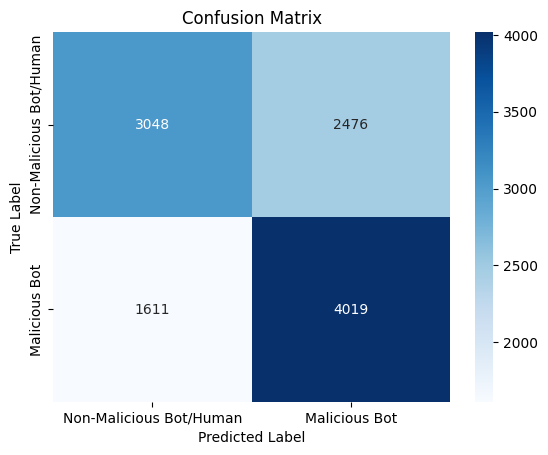

In [133]:
# using y_test and final_predictions, calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, baseline_model_predictions)

print("Confusion Matrix:")
print(cm)

# q: what is top left, top right, bottom left, bottom right?
# A: The confusion matrix is a 2x2 matrix where the rows represent the actual labels and the columns represent the predicted labels.
# The top-left cell (0, 0) represents the True Negatives (TN) - the number of non-malicious bots/humans that were correctly predicted.
# The top-right cell (0, 1) represents the False Positives (FP) - the number of non-malicious bots/humans that were incorrectly predicted as malicious bots.
# The bottom-left cell (1, 0) represents the False Negatives (FN) - the number of malicious bots that were incorrectly predicted as non-malicious bots/humans.
# The bottom-right cell (1, 1) represents the True Positives (TP) - the number of malicious bots that were correctly predicted.


# Optional: Print the confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap from the confusion matrix where first row is Actual Malicious Bot and second row is Actual Non-Malicious Bot/Human
# And the first column is Predicted Malicious Bot and second column is Predicted Non-Malicious Bot/Human
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Malicious Bot/Human', 'Malicious Bot'], yticklabels=['Non-Malicious Bot/Human', 'Malicious Bot'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:
[[2428 3096]
 [ 547 5083]]


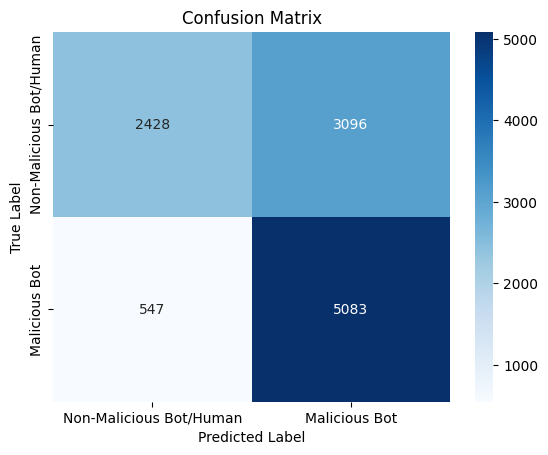

In [134]:
# using y_test and final_predictions, calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, proposed_model_predictions)

print("Confusion Matrix:")
print(cm)

# q: what is top left, top right, bottom left, bottom right?
# A: The confusion matrix is a 2x2 matrix where the rows represent the actual labels and the columns represent the predicted labels.
# The top-left cell (0, 0) represents the True Negatives (TN) - the number of non-malicious bots/humans that were correctly predicted.
# The top-right cell (0, 1) represents the False Positives (FP) - the number of non-malicious bots/humans that were incorrectly predicted as malicious bots.
# The bottom-left cell (1, 0) represents the False Negatives (FN) - the number of malicious bots that were incorrectly predicted as non-malicious bots/humans.
# The bottom-right cell (1, 1) represents the True Positives (TP) - the number of malicious bots that were correctly predicted.


# Optional: Print the confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap from the confusion matrix where first row is Actual Malicious Bot and second row is Actual Non-Malicious Bot/Human
# And the first column is Predicted Malicious Bot and second column is Predicted Non-Malicious Bot/Human
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Malicious Bot/Human', 'Malicious Bot'], yticklabels=['Non-Malicious Bot/Human', 'Malicious Bot'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [120]:
print("Baseline Model Metrics:")
for key, value in baseline_model_metrics.items():
	print(f"{key}: {value:.2f}")

print("\nProposed Model Metrics:")
for key, value in proposed_model_metrics.items():
	print(f"{key}: {value:.2f}")

Baseline Model Metrics:
accuracy: 0.63
precision: 0.62
recall: 0.71
f1_score: 0.66
mcc: 0.27

Proposed Model Metrics:
accuracy: 0.67
precision: 0.62
recall: 0.90
f1_score: 0.74
mcc: 0.39


In [132]:
# Calculate the mean differences between the metrics and use Paired T-Test to determine if the differences are statistically significant - consider p-value < 0.05 as significant

# Calculate the mean differences between the metrics
mean_diff = {}
for key in baseline_model_metrics.keys():
	mean_diff[key] = proposed_model_metrics[key] - baseline_model_metrics[key]

print("Mean Differences:")
for key, value in mean_diff.items():
	print(f"{key}: {value:.2f}")

# Perform Paired T-Test to determine if the differences are statistically significant
from scipy.stats import ttest_rel

# Extract the metric values from the dictionaries
baseline_values = list(baseline_model_metrics.values())
proposed_values = list(proposed_model_metrics.values())

# Perform the Paired T-Test
t_statistic, p_value = ttest_rel(proposed_values, baseline_values, alternative="greater")

# Determine if the differences are statistically significant
if p_value < 0.05:
	print("Null hypothesis rejected: The differences are statistically significant.")
else:
	print("Null hypothesis accepted: The differences are not statistically significant.")

print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.5f}")

Mean Differences:
accuracy: 0.04
precision: 0.00
recall: 0.19
f1_score: 0.07
mcc: 0.12
Null hypothesis rejected: The differences are statistically significant.
t-statistic: 2.6177
p-value: 0.02947
